In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=4, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [11]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 64
        self.conv2_out_channels = 96
        self.conv3_out_channels = 128
        self.conv4_out_channels = 128
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.LeakyReLU(0.05)          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.LeakyReLU(0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.LeakyReLU(0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.LeakyReLU(0.05)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.291)
        self.act_fc1 = nn.LeakyReLU(0.05)
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.334)
        self.act_fc2 = nn.LeakyReLU(0.05)
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.output_activation(self.fc3(x))
        
        return x

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.00046)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)


In [12]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [13]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [14]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
)

In [15]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc"
    patience=9,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [16]:
# Create logger
logger = TensorBoardLogger("tensorboard_logs", name="miniimagenet_cnn")

In [17]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [18]:
datamodule = DataModule(batch_size=64, num_workers=8)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=100)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 1.8 K  | train
1  | bn1               | BatchNorm2d | 128    | train
2  | act1              | LeakyReLU   | 0      | train
3  | pool1     

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]
Val - After Epoch 0: loss=3.907, acc=0.023
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 329/329 [03:14<00:00,  1.69it/s, v_num=14]
Val - After Epoch 0: loss=3.590, acc=0.090
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 329/329 [03:53<00:00,  1.41it/s, v_num=14]

Metric val_loss improved. New best score: 3.590



Train - After Epoch 0: loss=3.706, acc=0.071
Learning rate after epoch 0: 0.00046
[Epoch 0] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:13<00:00,  0.54it/s, v_num=14]
Val - After Epoch 1: loss=3.314, acc=0.145
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:52<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.276 >= min_delta = 0.0. New best score: 3.314



Train - After Epoch 1: loss=3.458, acc=0.113
Learning rate after epoch 1: 0.00046
[Epoch 1] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:06<00:00,  0.54it/s, v_num=14]
Val - After Epoch 2: loss=3.301, acc=0.150
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:45<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 3.301



Train - After Epoch 2: loss=3.337, acc=0.138
Learning rate after epoch 2: 0.00046
[Epoch 2] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:08<00:00,  0.54it/s, v_num=14]
Val - After Epoch 3: loss=3.135, acc=0.183
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:47<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 3.135



Train - After Epoch 3: loss=3.237, acc=0.159
Learning rate after epoch 3: 0.00046
[Epoch 3] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:09<00:00,  0.54it/s, v_num=14]
Val - After Epoch 4: loss=3.055, acc=0.202
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:48<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 3.055



Train - After Epoch 4: loss=3.142, acc=0.180
Learning rate after epoch 4: 0.00046
[Epoch 4] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:12<00:00,  0.54it/s, v_num=14]
Val - After Epoch 5: loss=2.961, acc=0.220
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:51<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 2.961



Train - After Epoch 5: loss=3.054, acc=0.198
Learning rate after epoch 5: 0.00046
[Epoch 5] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:08<00:00,  0.54it/s, v_num=14]
Val - After Epoch 6: loss=2.905, acc=0.251
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:47<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 2.905



Train - After Epoch 6: loss=2.979, acc=0.216
Learning rate after epoch 6: 0.00046
[Epoch 6] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:08<00:00,  0.54it/s, v_num=14]
Val - After Epoch 7: loss=2.851, acc=0.251
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:47<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 2.851



Train - After Epoch 7: loss=2.908, acc=0.236
Learning rate after epoch 7: 0.00046
[Epoch 7] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:09<00:00,  0.54it/s, v_num=14]
Val - After Epoch 8: loss=2.708, acc=0.284
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:49<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 2.708



Train - After Epoch 8: loss=2.840, acc=0.251
Learning rate after epoch 8: 0.00046
[Epoch 8] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:11<00:00,  0.54it/s, v_num=14]
Val - After Epoch 9: loss=2.782, acc=0.267
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 329/329 [10:51<00:00,  0.50it/s, v_num=14]
Train - After Epoch 9: loss=2.783, acc=0.261
Learning rate after epoch 9: 0.00046
[Epoch 9] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 10: 100%|████████████████████████████████████████████████████████████| 329/329 [12:17<00:00,  0.45it/s, v_num=14]
Val - After Epoch 10: loss=2.660, acc=0.291
Epoch 10: 100%|████████████████████████████████████████████████████████████| 329/329 [12:55<00:00,  0.42it/s, v_num=14]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 2.660



Train - After Epoch 10: loss=2.741, acc=0.275
Learning rate after epoch 10: 0.00046
[Epoch 10] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 11: 100%|████████████████████████████████████████████████████████████| 329/329 [10:05<00:00,  0.54it/s, v_num=14]
Val - After Epoch 11: loss=2.601, acc=0.304
Epoch 11: 100%|████████████████████████████████████████████████████████████| 329/329 [10:41<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 2.601



Train - After Epoch 11: loss=2.664, acc=0.291
Learning rate after epoch 11: 0.00046
[Epoch 11] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 12: 100%|████████████████████████████████████████████████████████████| 329/329 [10:04<00:00,  0.54it/s, v_num=14]
Val - After Epoch 12: loss=2.537, acc=0.328
Epoch 12: 100%|████████████████████████████████████████████████████████████| 329/329 [10:42<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 2.537



Train - After Epoch 12: loss=2.632, acc=0.294
Learning rate after epoch 12: 0.00046
[Epoch 12] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 13: 100%|████████████████████████████████████████████████████████████| 329/329 [10:01<00:00,  0.55it/s, v_num=14]
Val - After Epoch 13: loss=2.624, acc=0.306
Epoch 13: 100%|████████████████████████████████████████████████████████████| 329/329 [10:40<00:00,  0.51it/s, v_num=14]
Train - After Epoch 13: loss=2.575, acc=0.309
Learning rate after epoch 13: 0.00046
[Epoch 13] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 14: 100%|████████████████████████████████████████████████████████████| 329/329 [10:04<00:00,  0.54it/s, v_num=14]
Val - After Epoch 14: loss=2.472, acc=0.350
Epoch 14: 100%|████████████████████████████████████████████████████████████| 329/329 [10:44<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 2.472



Train - After Epoch 14: loss=2.531, acc=0.323
Learning rate after epoch 14: 0.00046
[Epoch 14] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 15: 100%|████████████████████████████████████████████████████████████| 329/329 [10:04<00:00,  0.54it/s, v_num=14]
Val - After Epoch 15: loss=2.501, acc=0.336
Epoch 15: 100%|████████████████████████████████████████████████████████████| 329/329 [10:43<00:00,  0.51it/s, v_num=14]
Train - After Epoch 15: loss=2.508, acc=0.325
Learning rate after epoch 15: 0.00046
[Epoch 15] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 16: 100%|████████████████████████████████████████████████████████████| 329/329 [10:01<00:00,  0.55it/s, v_num=14]
Val - After Epoch 16: loss=2.373, acc=0.364
Epoch 16: 100%|████████████████████████████████████████████████████████████| 329/329 [10:39<00:00,  0.51it/s, v_num=14]

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 2.373



Train - After Epoch 16: loss=2.461, acc=0.338
Learning rate after epoch 16: 0.00046
[Epoch 16] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 17: 100%|████████████████████████████████████████████████████████████| 329/329 [10:35<00:00,  0.52it/s, v_num=14]
Val - After Epoch 17: loss=2.400, acc=0.350
Epoch 17: 100%|████████████████████████████████████████████████████████████| 329/329 [11:12<00:00,  0.49it/s, v_num=14]
Train - After Epoch 17: loss=2.418, acc=0.344
Learning rate after epoch 17: 0.00046
[Epoch 17] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 18: 100%|████████████████████████████████████████████████████████████| 329/329 [09:52<00:00,  0.56it/s, v_num=14]
Val - After Epoch 18: loss=2.369, acc=0.370
Epoch 18: 100%|████████████████████████████████████████████████████████████| 329/329 [10:32<00:00,  0.52it/s, v_num=14]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 2.369



Train - After Epoch 18: loss=2.392, acc=0.351
Learning rate after epoch 18: 0.00046
[Epoch 18] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 19: 100%|████████████████████████████████████████████████████████████| 329/329 [10:06<00:00,  0.54it/s, v_num=14]
Val - After Epoch 19: loss=2.436, acc=0.343
Epoch 19: 100%|████████████████████████████████████████████████████████████| 329/329 [10:46<00:00,  0.51it/s, v_num=14]
Train - After Epoch 19: loss=2.348, acc=0.361
Learning rate after epoch 19: 0.00046
[Epoch 19] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 20: 100%|████████████████████████████████████████████████████████████| 329/329 [09:56<00:00,  0.55it/s, v_num=14]
Val - After Epoch 20: loss=2.346, acc=0.368
Epoch 20: 100%|████████████████████████████████████████████████████████████| 329/329 [10:34<00:00,  0.52it/s, v_num=14]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.346



Train - After Epoch 20: loss=2.326, acc=0.368
Learning rate after epoch 20: 0.00046
[Epoch 20] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 21: 100%|████████████████████████████████████████████████████████████| 329/329 [09:54<00:00,  0.55it/s, v_num=14]
Val - After Epoch 21: loss=2.317, acc=0.374
Epoch 21: 100%|████████████████████████████████████████████████████████████| 329/329 [10:34<00:00,  0.52it/s, v_num=14]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 2.317



Train - After Epoch 21: loss=2.296, acc=0.375
Learning rate after epoch 21: 0.00046
[Epoch 21] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 22: 100%|████████████████████████████████████████████████████████████| 329/329 [09:54<00:00,  0.55it/s, v_num=14]
Val - After Epoch 22: loss=2.245, acc=0.391
Epoch 22: 100%|████████████████████████████████████████████████████████████| 329/329 [10:32<00:00,  0.52it/s, v_num=14]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 2.245



Train - After Epoch 22: loss=2.264, acc=0.386
Learning rate after epoch 22: 0.00046
[Epoch 22] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 23: 100%|████████████████████████████████████████████████████████████| 329/329 [09:56<00:00,  0.55it/s, v_num=14]
Val - After Epoch 23: loss=2.296, acc=0.378
Epoch 23: 100%|████████████████████████████████████████████████████████████| 329/329 [10:36<00:00,  0.52it/s, v_num=14]
Train - After Epoch 23: loss=2.232, acc=0.389
Learning rate after epoch 23: 0.00046
[Epoch 23] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 24: 100%|████████████████████████████████████████████████████████████| 329/329 [09:50<00:00,  0.56it/s, v_num=14]
Val - After Epoch 24: loss=2.256, acc=0.403
Epoch 24: 100%|████████████████████████████████████████████████████████████| 329/329 [10:30<00:00,  0.52it/s, v_num=14]
Train - After Epoch 24: loss=2.206, acc=0.396
Learning rate after epoch 24: 0.00046
[Epoch 24] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 2.150



Train - After Epoch 25: loss=2.179, acc=0.404
Learning rate after epoch 25: 0.00046
[Epoch 25] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 26: 100%|████████████████████████████████████████████████████████████| 329/329 [09:47<00:00,  0.56it/s, v_num=14]
Val - After Epoch 26: loss=2.180, acc=0.408
Epoch 26: 100%|████████████████████████████████████████████████████████████| 329/329 [10:28<00:00,  0.52it/s, v_num=14]
Train - After Epoch 26: loss=2.158, acc=0.407
Learning rate after epoch 26: 0.00046
[Epoch 26] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 27: 100%|████████████████████████████████████████████████████████████| 329/329 [10:43<00:00,  0.51it/s, v_num=14]
Val - After Epoch 27: loss=2.203, acc=0.411
Epoch 27: 100%|████████████████████████████████████████████████████████████| 329/329 [11:25<00:00,  0.48it/s, v_num=14]
Train - After Epoch 27: loss=2.131, acc=0.413
Learning rate after epoch 27: 0.00046
[Epoch 27] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 2.048



Train - After Epoch 30: loss=1.987, acc=0.448
Learning rate after epoch 30: 0.00023
[Epoch 30] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 31: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 31: loss=1.994, acc=0.454
Epoch 31: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.994



Train - After Epoch 31: loss=1.942, acc=0.462
Learning rate after epoch 31: 0.00023
[Epoch 31] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 32: 100%|████████████████████████████████████████████████████████████| 329/329 [10:19<00:00,  0.53it/s, v_num=14]
Val - After Epoch 32: loss=2.050, acc=0.445
Epoch 32: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]
Train - After Epoch 32: loss=1.929, acc=0.465
Learning rate after epoch 32: 0.00023
[Epoch 32] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 33: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 33: loss=2.082, acc=0.438
Epoch 33: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 33: loss=1.903, acc=0.473
Learning rate after epoch 33: 0.00023
[Epoch 33] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.955



Train - After Epoch 34: loss=1.885, acc=0.473
Learning rate after epoch 34: 0.00023
[Epoch 34] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 35: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 35: loss=1.971, acc=0.468
Epoch 35: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 35: loss=1.877, acc=0.475
Learning rate after epoch 35: 0.00023
[Epoch 35] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 36: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 36: loss=1.939, acc=0.465
Epoch 36: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.939



Train - After Epoch 36: loss=1.855, acc=0.478
Learning rate after epoch 36: 0.00023
[Epoch 36] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 37: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 37: loss=1.960, acc=0.471
Epoch 37: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 37: loss=1.845, acc=0.482
Learning rate after epoch 37: 0.00023
[Epoch 37] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 38: 100%|████████████████████████████████████████████████████████████| 329/329 [10:19<00:00,  0.53it/s, v_num=14]
Val - After Epoch 38: loss=1.948, acc=0.472
Epoch 38: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]
Train - After Epoch 38: loss=1.832, acc=0.488
Learning rate after epoch 38: 0.00023
[Epoch 38] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.936



Train - After Epoch 39: loss=1.818, acc=0.492
Learning rate after epoch 39: 0.00023
[Epoch 39] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 40: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 40: loss=1.959, acc=0.471
Epoch 40: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 40: loss=1.808, acc=0.493
Learning rate after epoch 40: 0.00023
[Epoch 40] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 41: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 41: loss=1.930, acc=0.477
Epoch 41: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.930



Train - After Epoch 41: loss=1.785, acc=0.499
Learning rate after epoch 41: 0.00023
[Epoch 41] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 42: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 42: loss=1.983, acc=0.463
Epoch 42: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 42: loss=1.775, acc=0.504
Learning rate after epoch 42: 0.00023
[Epoch 42] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 43: 100%|████████████████████████████████████████████████████████████| 329/329 [10:19<00:00,  0.53it/s, v_num=14]
Val - After Epoch 43: loss=1.933, acc=0.474
Epoch 43: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]
Train - After Epoch 43: loss=1.770, acc=0.502
Learning rate after epoch 43: 0.00023
[Epoch 43] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.922



Train - After Epoch 44: loss=1.744, acc=0.507
Learning rate after epoch 44: 0.00023
[Epoch 44] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 45: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 45: loss=1.867, acc=0.490
Epoch 45: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.867



Train - After Epoch 45: loss=1.744, acc=0.509
Learning rate after epoch 45: 0.00023
[Epoch 45] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 46: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 46: loss=1.967, acc=0.469
Epoch 46: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 46: loss=1.736, acc=0.513
Learning rate after epoch 46: 0.00023
[Epoch 46] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 47: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 47: loss=1.892, acc=0.486
Epoch 47: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 47: loss=1.734, acc=0.509
Learning rate after epoch 47: 0.00023
[Epoch 47] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.861



Train - After Epoch 49: loss=1.705, acc=0.518
Learning rate after epoch 49: 0.00023
[Epoch 49] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 50: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 50: loss=1.862, acc=0.492
Epoch 50: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 50: loss=1.682, acc=0.523
Learning rate after epoch 50: 0.00023
[Epoch 50] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 51: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 51: loss=1.890, acc=0.489
Epoch 51: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 51: loss=1.676, acc=0.526
Learning rate after epoch 51: 0.00023
[Epoch 51] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.838



Train - After Epoch 53: loss=1.645, acc=0.536
Learning rate after epoch 53: 0.00023
[Epoch 53] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 54: 100%|████████████████████████████████████████████████████████████| 329/329 [10:19<00:00,  0.53it/s, v_num=14]
Val - After Epoch 54: loss=1.905, acc=0.486
Epoch 54: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]
Train - After Epoch 54: loss=1.646, acc=0.534
Learning rate after epoch 54: 0.00023
[Epoch 54] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 55: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 55: loss=1.875, acc=0.491
Epoch 55: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 55: loss=1.620, acc=0.541
Learning rate after epoch 55: 0.00023
[Epoch 55] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.823



Train - After Epoch 56: loss=1.625, acc=0.536
Learning rate after epoch 56: 0.00023
[Epoch 56] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 57: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 57: loss=1.859, acc=0.500
Epoch 57: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 57: loss=1.618, acc=0.541
Learning rate after epoch 57: 0.00023
[Epoch 57] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 58: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 58: loss=1.840, acc=0.501
Epoch 58: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 58: loss=1.608, acc=0.542
Learning rate after epoch 58: 0.00023
[Epoch 58] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.805



Train - After Epoch 59: loss=1.598, acc=0.549
Learning rate after epoch 59: 0.00023
[Epoch 59] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 60: 100%|████████████████████████████████████████████████████████████| 329/329 [10:19<00:00,  0.53it/s, v_num=14]
Val - After Epoch 60: loss=1.856, acc=0.500
Epoch 60: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 60: loss=1.594, acc=0.546
Learning rate after epoch 60: 0.00023
[Epoch 60] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 61: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 61: loss=1.847, acc=0.498
Epoch 61: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 61: loss=1.567, acc=0.554
Learning rate after epoch 61: 0.00023
[Epoch 61] Grad Norms — Total: 22, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.791



Train - After Epoch 64: loss=1.518, acc=0.565
Learning rate after epoch 64: 0.000115
[Epoch 64] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 65: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 65: loss=1.774, acc=0.512
Epoch 65: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.774



Train - After Epoch 65: loss=1.479, acc=0.577
Learning rate after epoch 65: 0.000115
[Epoch 65] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 66: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 66: loss=1.748, acc=0.522
Epoch 66: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.748



Train - After Epoch 66: loss=1.493, acc=0.574
Learning rate after epoch 66: 0.000115
[Epoch 66] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 67: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 67: loss=1.746, acc=0.529
Epoch 67: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.746



Train - After Epoch 67: loss=1.463, acc=0.578
Learning rate after epoch 67: 0.000115
[Epoch 67] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 68: 100%|████████████████████████████████████████████████████████████| 329/329 [10:16<00:00,  0.53it/s, v_num=14]
Val - After Epoch 68: loss=1.746, acc=0.528
Epoch 68: 100%|████████████████████████████████████████████████████████████| 329/329 [10:57<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.746



Train - After Epoch 68: loss=1.471, acc=0.576
Learning rate after epoch 68: 0.000115
[Epoch 68] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 69: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 69: loss=1.748, acc=0.523
Epoch 69: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]
Train - After Epoch 69: loss=1.477, acc=0.576
Learning rate after epoch 69: 0.000115
[Epoch 69] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 70: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 70: loss=1.752, acc=0.535
Epoch 70: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 70: loss=1.454, acc=0.582
Learning rate after epoch 70: 0.000115
[Epoch 70] Grad Norms — Total: 22, Vanished: 3, Exploded

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.744



Train - After Epoch 71: loss=1.447, acc=0.583
Learning rate after epoch 71: 0.000115
[Epoch 71] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 72: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 72: loss=1.743, acc=0.518
Epoch 72: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.743



Train - After Epoch 72: loss=1.443, acc=0.583
Learning rate after epoch 72: 0.000115
[Epoch 72] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 73: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 73: loss=1.751, acc=0.525
Epoch 73: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 73: loss=1.441, acc=0.582
Learning rate after epoch 73: 0.000115
[Epoch 73] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 74: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 74: loss=1.762, acc=0.526
Epoch 74: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 74: loss=1.429, acc=0.587
Learning rate after epoch 74: 0.000115
[Epoch 74] Grad Norms — Total: 22, Vanished: 3, Exploded

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.722



Train - After Epoch 77: loss=1.386, acc=0.600
Learning rate after epoch 77: 5.75e-05
[Epoch 77] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 78: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 78: loss=1.705, acc=0.535
Epoch 78: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.705



Train - After Epoch 78: loss=1.385, acc=0.601
Learning rate after epoch 78: 5.75e-05
[Epoch 78] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 79: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 79: loss=1.698, acc=0.544
Epoch 79: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.698



Train - After Epoch 79: loss=1.371, acc=0.602
Learning rate after epoch 79: 5.75e-05
[Epoch 79] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 80: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 80: loss=1.695, acc=0.537
Epoch 80: 100%|████████████████████████████████████████████████████████████| 329/329 [10:59<00:00,  0.50it/s, v_num=14]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.695



Train - After Epoch 80: loss=1.382, acc=0.600
Learning rate after epoch 80: 5.75e-05
[Epoch 80] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 81: 100%|████████████████████████████████████████████████████████████| 329/329 [10:18<00:00,  0.53it/s, v_num=14]
Val - After Epoch 81: loss=1.742, acc=0.527
Epoch 81: 100%|████████████████████████████████████████████████████████████| 329/329 [11:00<00:00,  0.50it/s, v_num=14]
Train - After Epoch 81: loss=1.368, acc=0.606
Learning rate after epoch 81: 5.75e-05
[Epoch 81] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 82: 100%|████████████████████████████████████████████████████████████| 329/329 [10:48<00:00,  0.51it/s, v_num=14]
Val - After Epoch 82: loss=1.733, acc=0.534
Epoch 82: 100%|████████████████████████████████████████████████████████████| 329/329 [11:30<00:00,  0.48it/s, v_num=14]
Train - After Epoch 82: loss=1.362, acc=0.609
Learning rate after epoch 82: 5.75e-05
[Epoch 82] Grad Norms — Total: 22, Vanished: 3, Exploded

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.679



Train - After Epoch 87: loss=1.334, acc=0.613
Learning rate after epoch 87: 2.875e-05
[Epoch 87] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 88: 100%|████████████████████████████████████████████████████████████| 329/329 [10:21<00:00,  0.53it/s, v_num=14]
Val - After Epoch 88: loss=1.697, acc=0.541
Epoch 88: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]
Train - After Epoch 88: loss=1.332, acc=0.613
Learning rate after epoch 88: 2.875e-05
[Epoch 88] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 89: 100%|████████████████████████████████████████████████████████████| 329/329 [10:23<00:00,  0.53it/s, v_num=14]
Val - After Epoch 89: loss=1.685, acc=0.543
Epoch 89: 100%|████████████████████████████████████████████████████████████| 329/329 [11:02<00:00,  0.50it/s, v_num=14]
Train - After Epoch 89: loss=1.329, acc=0.611
Learning rate after epoch 89: 2.875e-05
[Epoch 89] Grad Norms — Total: 22, Vanished: 3, Explo

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.671



Train - After Epoch 90: loss=1.332, acc=0.613
Learning rate after epoch 90: 2.875e-05
[Epoch 90] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 91: 100%|████████████████████████████████████████████████████████████| 329/329 [09:50<00:00,  0.56it/s, v_num=14]
Val - After Epoch 91: loss=1.686, acc=0.544
Epoch 91: 100%|████████████████████████████████████████████████████████████| 329/329 [10:30<00:00,  0.52it/s, v_num=14]
Train - After Epoch 91: loss=1.334, acc=0.613
Learning rate after epoch 91: 2.875e-05
[Epoch 91] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 92: 100%|████████████████████████████████████████████████████████████| 329/329 [10:23<00:00,  0.53it/s, v_num=14]
Val - After Epoch 92: loss=1.691, acc=0.544
Epoch 92: 100%|████████████████████████████████████████████████████████████| 329/329 [11:03<00:00,  0.50it/s, v_num=14]
Train - After Epoch 92: loss=1.333, acc=0.614
Learning rate after epoch 92: 2.875e-05
[Epoch 92] Grad Norms — Total: 22, Vanished: 3, Explo

Monitored metric val_loss did not improve in the last 9 records. Best score: 1.671. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=100` reached.



Train - After Epoch 99: loss=1.305, acc=0.619
Learning rate after epoch 99: 7.1875e-06
[Epoch 99] Grad Norms — Total: 22, Vanished: 3, Exploded: 0
Epoch 99: 100%|████████████████████████████████████████████████████████████| 329/329 [11:01<00:00,  0.50it/s, v_num=14]


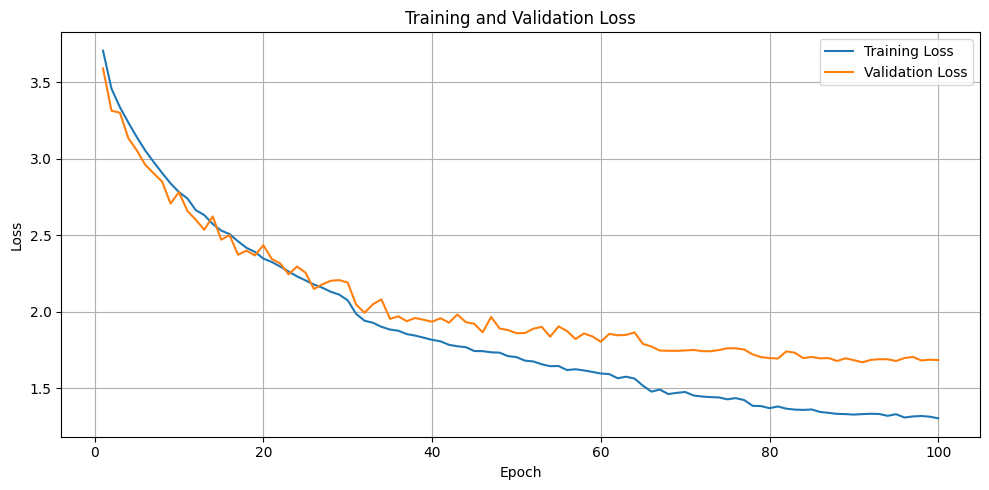

In [19]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

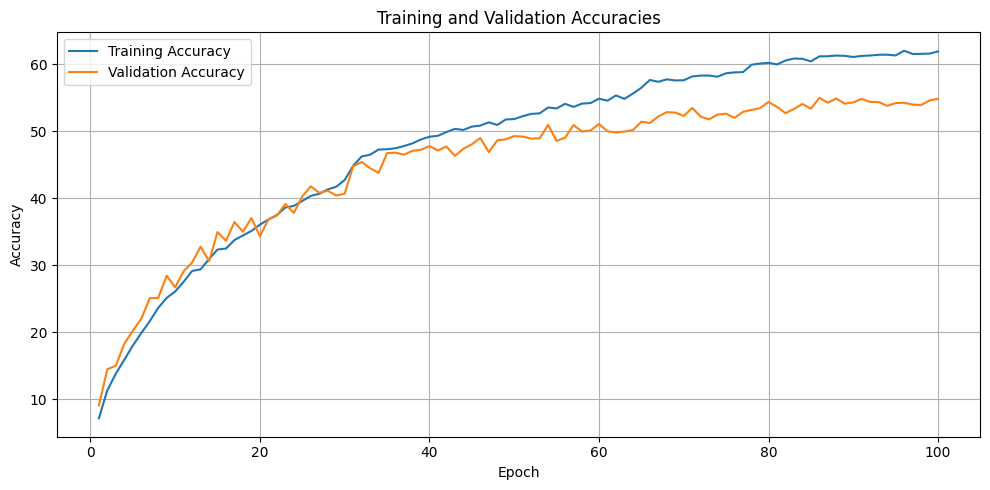

In [20]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())

# Count only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 13306066
Trainable parameters: 13306066


#### Model size: 13.3 million parameters